In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
%matplotlib inline

### Data

In [2]:
# date
numdays = 365*10 + 2
base = '2010-01-01'
base = datetime.strptime(base, '%Y-%m-%d')
date_list = [base + timedelta(days=x) for x in range(numdays)]
date_list = np.array(date_list)
print(len(date_list), date_list[0], date_list[-1])

# temp
x = np.linspace(-np.pi, np.pi, 365)
temp_year = (np.sin(x) + 1.0) * 15
x = np.linspace(-np.pi, np.pi, 366)
temp_leap_year = (np.sin(x) + 1.0)
temp_s = []
for i in range(2010, 2020):
    if i == 2010:
        temp_s = temp_year + np.random.rand(365) * 20
    elif i in [2012, 2016]:
        temp_s = np.concatenate((temp_s, temp_leap_year * 15 + np.random.rand(366) * 20 + i % 2010))
    else:
        temp_s = np.concatenate((temp_s, temp_year + np.random.rand(365) * 20 + i % 2010))
print(len(temp_s))

# df
data = np.concatenate((date_list.reshape(-1, 1), temp_s.reshape(-1, 1)), axis=1)
df_orig = pd.DataFrame(data, columns=['date', 'temp'])
df_orig['date'] =  pd.to_datetime(df_orig['date'], format='%Y-%m-%d')
df = df_orig.set_index('date')
df.sort_index(inplace=True)
df

3652 2010-01-01 00:00:00 2019-12-31 00:00:00
3652


,temp
date,
2010-01-01,24.250578
2010-01-02,23.082646
2010-01-03,32.234088
2010-01-04,20.049375
2010-01-05,22.786465
...,...
2019-12-27,39.043239
2019-12-28,32.971862
2019-12-29,31.319509


Text(0, 0.5, 'temperature')

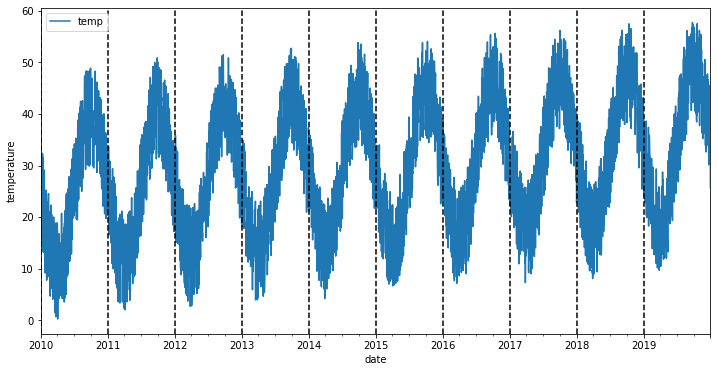

In [3]:
ax = df_orig.plot(x='date', y='temp', figsize=(12,6))
xcoords = ['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
           '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
ax.set_ylabel('temperature')

### Decomposing the data

In [4]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=365)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual

<ipython-input-4-76e7b9524102>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=365)


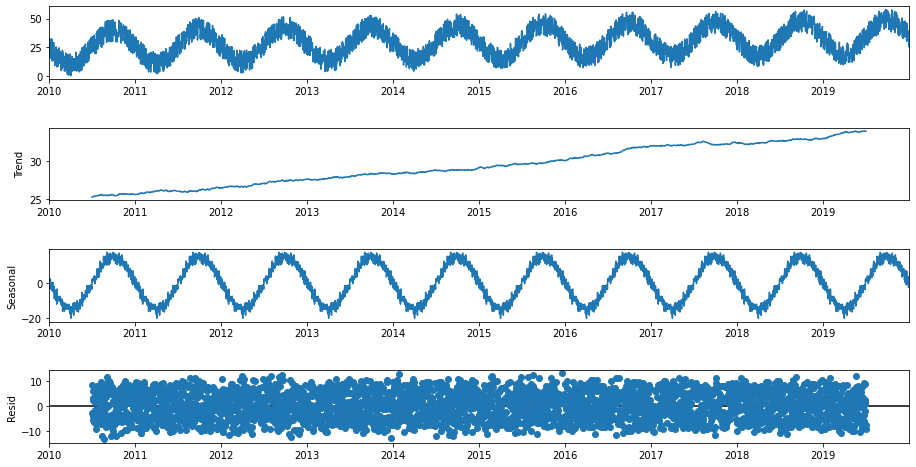

(date
 2010-01-01   NaN
 2010-01-02   NaN
 2010-01-03   NaN
 2010-01-04   NaN
 2010-01-05   NaN
               ..
 2019-12-27   NaN
 2019-12-28   NaN
 2019-12-29   NaN
 2019-12-30   NaN
 2019-12-31   NaN
 Name: trend, Length: 3652, dtype: float64,
 date
 2010-01-01   -2.494146
 2010-01-02    0.257627
 2010-01-03   -2.380844
 2010-01-04   -3.313862
 2010-01-05   -1.208113
                 ...   
 2019-12-27    2.035327
 2019-12-28    3.715526
 2019-12-29   -0.356290
 2019-12-30   -2.494146
 2019-12-31    0.257627
 Name: seasonal, Length: 3652, dtype: float64,
 date
 2010-01-01   NaN
 2010-01-02   NaN
 2010-01-03   NaN
 2010-01-04   NaN
 2010-01-05   NaN
               ..
 2019-12-27   NaN
 2019-12-28   NaN
 2019-12-29   NaN
 2019-12-30   NaN
 2019-12-31   NaN
 Name: resid, Length: 3652, dtype: float64)

In [5]:
seasonal_decompose(df)

### Checking Stationarity

#### Visualization: Graphing the rolling statistics

In [6]:
def analyze_stationarity(timeseries, title):
    rolmean = pd.Series(timeseries).rolling(window=30).mean() 
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

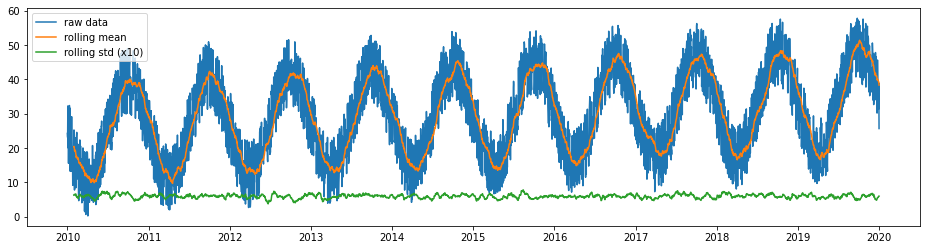

In [7]:
pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(df['temp'], 'raw data')

#### Augmented Dickey-Fuller Test

https://www.statology.org/dickey-fuller-test-python/

- H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.
- H1: The time series is stationary.

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
- H0: The process is trend stationary.
- H1: The series has a unit root (series is not stationary).

In [8]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [9]:
ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                  -3.43110076
p-value                          0.00994325
Lags Used                       30.00000000
Number of Observations Used   3621.00000000
Critical Value (1%)             -3.43215722
Critical Value (5%)             -2.86233853
Critical Value (10%)            -2.56719507
dtype: float64


In [10]:
def KPSS_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")    
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [11]:
KPSS_test(df)

Results of KPSS Test:
Test Statistic           1.03230056
p-value                  0.01000000
Lags Used               37.00000000
Critical Value (10%)     0.34700000
Critical Value (5%)      0.46300000
Critical Value (2.5%)    0.57400000
Critical Value (1%)      0.73900000
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [12]:
# Checking stationarity with linear time-series
y_test = df.copy()
tmp = []
for i in range(len(y_test)):
    tmp.append(i)
y_test['temp'] = tmp
ADF_test(y_test)

Results of Dickey-Fuller Test:
Test Statistic                  35.10770722
p-value                          1.00000000
Lags Used                       25.00000000
Number of Observations Used   3626.00000000
Critical Value (1%)             -3.43215473
Critical Value (5%)             -2.86233743
Critical Value (10%)            -2.56719448
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [13]:
# Checking stationarity with sinusoidal data
y_test = df.copy()
tmp = []
for i in range(len(y_test)):
    tmp.append(np.sin(np.pi/2 * i / 365 + 1))
y_test['temp'] = tmp
ADF_test(y_test)

Results of Dickey-Fuller Test:
Test Statistic                -2942438831649.71679688
p-value                                    0.00000000
Lags Used                                  5.00000000
Number of Observations Used             3646.00000000
Critical Value (1%)                       -3.43214482
Critical Value (5%)                       -2.86233305
Critical Value (10%)                      -2.56719215
dtype: float64


### Checking Trending

#### Detrending

Results of Dickey-Fuller Test:
Test Statistic                  -2.73252830
p-value                          0.06857660
Lags Used                       13.00000000
Number of Observations Used   3274.00000000
Critical Value (1%)             -3.43234891
Critical Value (5%)             -2.86242320
Critical Value (10%)            -2.56724015
dtype: float64


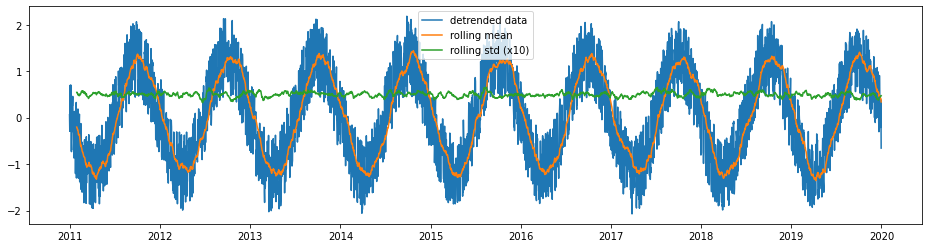

In [14]:
df_detrend = (df - df.rolling(window=365).mean()) / df.rolling(window=365).std()

analyze_stationarity(df_detrend['temp'].dropna(), 'detrended data')
ADF_test(df_detrend.dropna())

#### Differencing

Results of Dickey-Fuller Test:
Test Statistic                 -55.45289751
p-value                          0.00000000
Lags Used                        0.00000000
Number of Observations Used   3286.00000000
Critical Value (1%)             -3.43234161
Critical Value (5%)             -2.86241997
Critical Value (10%)            -2.56723843
dtype: float64


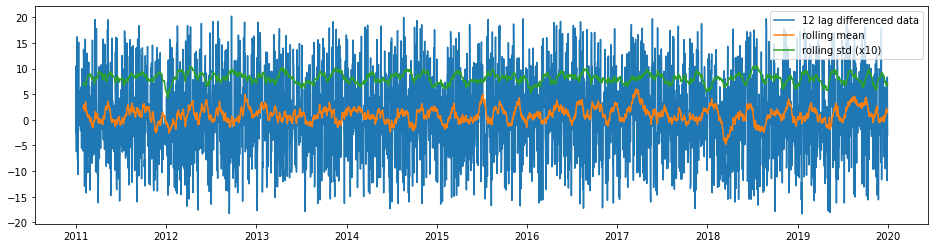

In [15]:
df_365lag =  df - df.shift(365)

analyze_stationarity(df_365lag['temp'].dropna(), '12 lag differenced data')
ADF_test(df_365lag.dropna())

#### Detrending + Differencing

Results of Dickey-Fuller Test:
Test Statistic                 -52.20603773
p-value                          0.00000000
Lags Used                        0.00000000
Number of Observations Used   2922.00000000
Critical Value (1%)             -3.43258992
Critical Value (5%)             -2.86252965
Critical Value (10%)            -2.56729682
dtype: float64


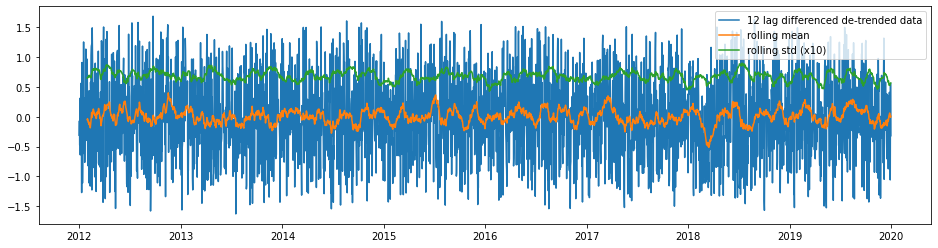

In [16]:
df_365lag_detrend =  df_detrend - df_detrend.shift(365)

analyze_stationarity(df_365lag_detrend['temp'].dropna(), '12 lag differenced de-trended data')
ADF_test(df_365lag_detrend.dropna())

### Create Training & Testing Datasets

In [17]:
y = df['temp'].astype(float)
y_to_train = y[:'2017-12-31']
y_to_val = y['2018-01-01':]
predict_date = len(y) - len(y[:'2017-12-31'])

### Forecasting models

#### Holt-Winters’ Seasonal Method

Suitable for time series data with trend and/or seasonal components

In [18]:
def holt_win_sea(y, y_to_train, y_to_test, seasonal_period, predict_date):
    
    fit1 = ExponentialSmoothing(y_to_train, seasonal_periods=seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
    fcast1 = fit1.forecast(predict_date).rename('Additive')
    mse1 = ((fcast1 - y_to_test.values) ** 2).mean()
    print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
          'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

    y.plot(marker='o', color='black', legend=True, figsize=(10, 5))
    fit1.fittedvalues.plot(style='--', color='red', label='train')
    fcast1.plot(style='--', color='green', label='test')
    plt.ylabel('temp')
    plt.title('Additive trend and seasonal')
    plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=365 and a Box-Cox transformation 6.27


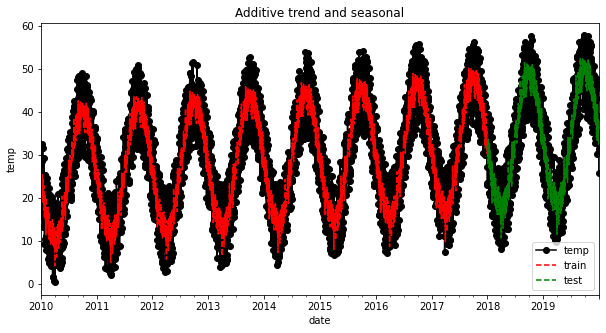

In [19]:
holt_win_sea(y, y_to_train, y_to_val, 365, predict_date)